
OLS SUMMARY

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     187.6
Date:                Sun, 22 Oct 2023   Prob (F-statistic):           4.06e-81
Time:                        04:25:01   Log-Likelihood:                -239.56
No. Observations:                 312   AIC:                             489.1
Df Residuals:                     307   BIC:                             507.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0349      0.030

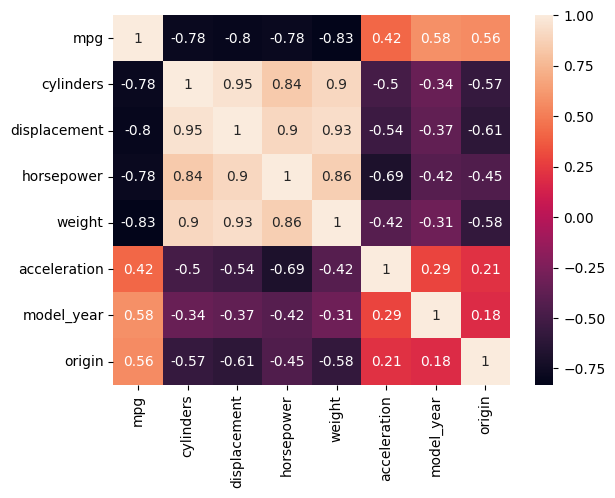

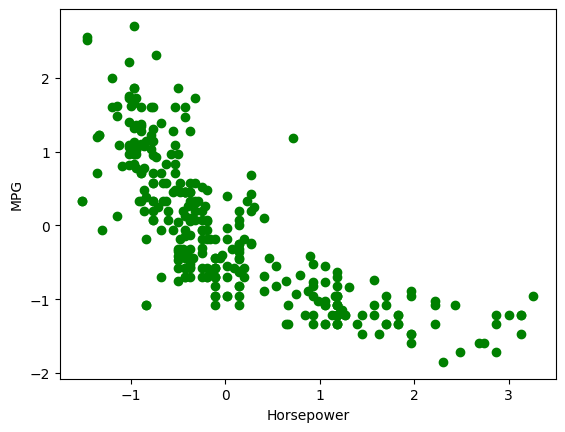

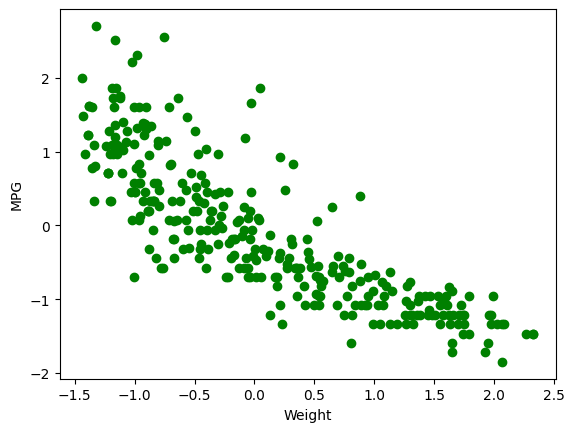

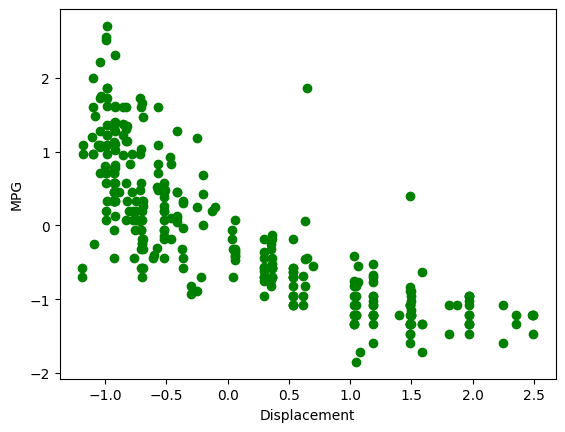

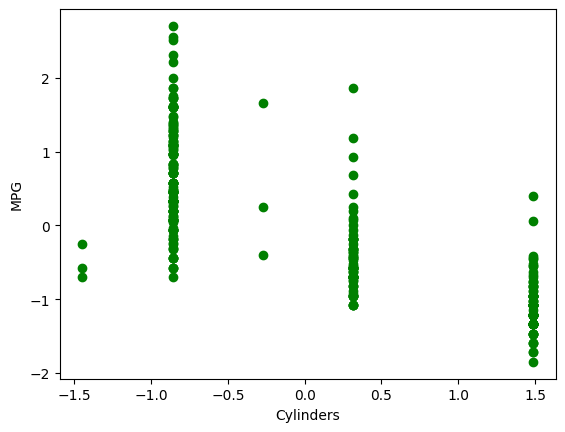


DECISION TREE REGRESSOR


Best Decision Tree Regressor Parameters: {'max_depth': 11, 'max_leaf_nodes': 30, 'min_samples_leaf': 9, 'splitter': 'random'}


MSE for Decision Tree Regressor: 0.3361788982563062



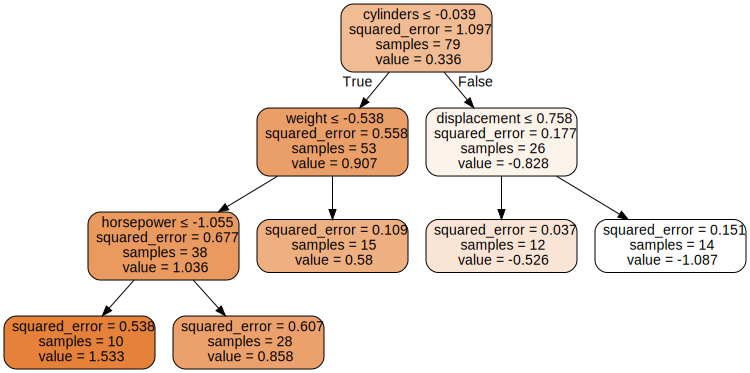


RANDOM FOREST TREE REGRESSOR


Best Random Forest Tree Regressor Parameters: {'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 200}


MSE for Random Forest Tree Regressor: 0.5238543228916294



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


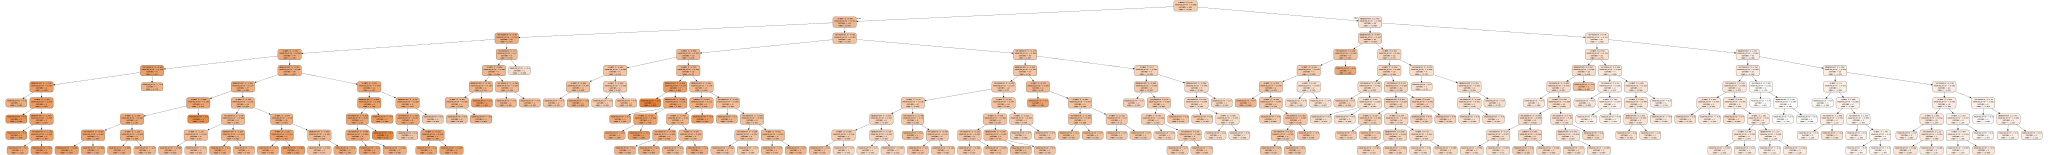


ADABOOST REGRESSOR


Best Adaboost Regressor Parameters: {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 50, 'random_state': 80}


MSE for Adaboost Regressor: 0.2474095135871816



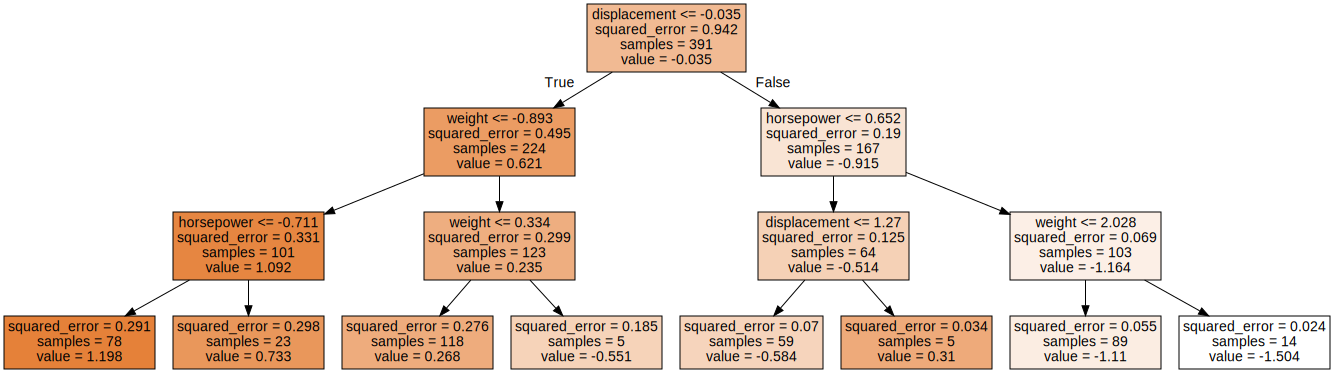


XGBOOST REGRESSOR


Best XGBoost Regressor Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_leaves': 3, 'n_estimators': 50}


MSE for XGBoost Regressor: 0.2316549370594025



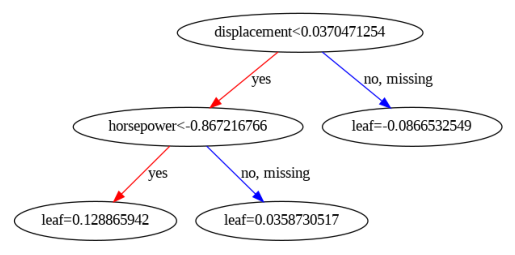

In [106]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import graphviz
from sklearn import tree
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import export_graphviz
from xgboost import XGBRegressor
from xgboost import plot_tree
import matplotlib.pyplot as plt


#load dataset
cars = pd.read_csv('https://raw.githubusercontent.com/Jerpac/CS4375/main/auto-mpg.data', delim_whitespace = True)

#normalize variables
cars.columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name']

cars = cars.dropna()
cars = cars.drop_duplicates()
cars = cars.drop(cars[cars['horsepower'] == '?'].index)

cars["cylinders"] = pd.to_numeric(cars["cylinders"], downcast="integer")
cars["displacement"] = pd.to_numeric(cars["displacement"], downcast="float")
cars["horsepower"] = pd.to_numeric(cars["horsepower"], downcast="float")
cars["model_year"] = pd.to_numeric(cars["model_year"], downcast="integer")
cars['weight'] = pd.to_numeric(cars['weight'], downcast='float')
cars['origin'] = pd.to_numeric(cars['origin'], downcast='integer')

cars = cars.reset_index(drop=True)

# look at variables that best correlate with mpg
correlate_visual = cars.corr(numeric_only=True).round(2)
sns.heatmap(data = correlate_visual, annot = True)
cars = cars[['mpg', 'weight', 'horsepower', 'displacement', 'cylinders']]

# set well-correlated variables to X
X = cars[['weight', 'horsepower', 'displacement', 'cylinders']]
Y = cars['mpg']

#normalize data
Y = np.array((Y - Y.mean())/Y.std())
X = X.apply(lambda rec:(rec-rec.mean())/rec.std(), axis=0)

#split the data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)

# OLS SUMMARY

X_train_off = sm.add_constant(x_train)
sm_reg = sm.OLS(y_train, X_train_off)

OLS_model = sm_reg.fit()
print('\nOLS SUMMARY\n')
print(OLS_model.summary())

# PLOTS
print('\nPLOTS\n')
plt.figure()
plt.scatter(x_train['horsepower'], y_train,color='g')
plt.xlabel('Horsepower')
plt.ylabel('MPG')
plt.show()
plt.scatter(x_train['weight'], y_train,color='g')
plt.xlabel('Weight')
plt.ylabel('MPG')
plt.show()
plt.scatter(x_train['displacement'], y_train,color='g')
plt.xlabel('Displacement')
plt.ylabel('MPG')
plt.show()
plt.scatter(x_train['cylinders'], y_train,color='g')
plt.xlabel('Cylinders')
plt.ylabel('MPG')
plt.show()


# Decision Tree Regressor

print('\nDECISION TREE REGRESSOR\n')
dtr=DecisionTreeRegressor()
dtr.fit(X,Y)
dtr_params={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

dtr_tuner=GridSearchCV(dtr,param_grid=dtr_params,scoring='neg_mean_squared_error',cv=3)
dtr_tuner.fit(x_train,y_train)
dtr_params = dtr_tuner.best_params_
print(f'\nBest Decision Tree Regressor Parameters: {dtr_params}\n')
dtr2 = DecisionTreeRegressor(max_depth = dtr_params['max_depth'], max_leaf_nodes = dtr_params['max_leaf_nodes'],min_samples_leaf=dtr_params['min_samples_leaf'],splitter=dtr_params['splitter'])
dtr2 = dtr2.fit(x_test, y_test)

dot_data = tree.export_graphviz(dtr2, out_file=None,
                     feature_names=X.columns,
                     class_names=Y,
                     filled=True, rounded=True,
                     special_characters=True)
dtr_graph = graphviz.Source(dot_data)
dtr_y_pred = dtr2.predict(x_test)
print(f'\nMSE for Decision Tree Regressor: {mean_squared_error(y_test,dtr_y_pred)}\n')

display(dtr_graph)

# Random Forest
print('\nRANDOM FOREST TREE REGRESSOR\n')
rf=RandomForestRegressor()
rfparams={'max_depth': [5,7,9],
          'n_estimators': [50, 100, 200],
          'max_features': ['sqrt','log2']
          }
rf_grid = GridSearchCV(rf, rfparams, cv=10, scoring='neg_mean_squared_error', return_train_score=False)
rf_grid.fit(X, Y)
rfparams = rf_grid.best_params_
print(f'\nBest Random Forest Tree Regressor Parameters: {rfparams}\n')

rfestimator = RandomForestRegressor(max_depth = rfparams['max_depth'], max_features = rfparams['max_features'], n_estimators=rfparams['n_estimators'])
rfestimator.fit(x_train,y_train)
rftree1 = rfestimator.estimators_[0]
rftree1
rfdot_data = tree.export_graphviz(rftree1, out_file=None,
                     feature_names=X.columns,
                     class_names=Y,
                     filled=True, rounded=True,
                     special_characters=True)
rfgraph = graphviz.Source(rfdot_data)
rftree1_y_pred = rftree1.predict(x_test)
print(f'\nMSE for Random Forest Tree Regressor: {mean_squared_error(y_test,rftree1_y_pred)}\n')
display(rfgraph)

# ADABOOST REGRESSOR
print('\nADABOOST REGRESSOR\n')

abr=AdaBoostRegressor()
abr.fit(X,Y)

ada_params={"n_estimators":[10, 50, 100, 250],
            "learning_rate" : [0.1, 0.01, 0.001],
           "random_state":[4, 30, 50, 80, 100, 200],
           "loss":['linear', 'square', 'exponential'] }

ada_tuner=GridSearchCV(abr,param_grid=ada_params,scoring='neg_mean_squared_error',cv=3)
ada_tuner.fit(x_train,y_train)
ada_params = ada_tuner.best_params_
print(f'\nBest Adaboost Regressor Parameters: {ada_params}\n')

abr2=AdaBoostRegressor(n_estimators = ada_params['n_estimators'], learning_rate = ada_params['learning_rate'], random_state = ada_params['random_state'], loss = ada_params['loss'])
abr2.fit(X,Y)

abr_tree = abr2.estimators_[0]

abr_data = export_graphviz(abr_tree, out_file = None, feature_names = X.columns, filled = True)
abr_graph = graphviz.Source(abr_data)
abr_y_pred = abr2.predict(x_test)
print(f'\nMSE for Adaboost Regressor: {mean_squared_error(y_test,abr_y_pred)}\n')
display(abr_graph)

# XGBOOST REGRESSOR
print('\nXGBOOST REGRESSOR\n')

xgbr = XGBRegressor()
xgbr.fit(X, Y)
xgbr_params={'n_estimators':[10, 50, 100, 250],
            'learning_rate' : [0.1, 0.01, 0.001],
           'max_depth':[3, 5, 7, 8],
          'max_leaves': [0, 1, 3, 5, 8, 10]}

xgbr_tuner=GridSearchCV(xgbr,param_grid=xgbr_params,scoring='neg_mean_squared_error',cv=3)
xgbr_tuner.fit(x_train,y_train)
xgbr_params = xgbr_tuner.best_params_
print(f'\nBest XGBoost Regressor Parameters: {xgbr_params}\n')


xgbr2 = XGBRegressor(n_estimators = xgbr_params['n_estimators'], learning_rate = xgbr_params['learning_rate'], max_depth = xgbr_params['max_depth'], max_leaves = xgbr_params['max_leaves'])
xgbr2.fit(X,Y)
xgbr_y_pred = xgbr2.predict(x_test)
print(f'\nMSE for XGBoost Regressor: {mean_squared_error(y_test,xgbr_y_pred)}\n')
plot_tree(xgbr2)
plt.show()